# Table of contents

1. [Kaggle Week 5 Competition](#kaggle-week-5-competition)
2. [Description of the problem and Data](#description-of-the-problem-and-data)
3. [Utils section](#utils-section)
4. [Exploratory Data Analysis (EDA) - Inspect, visualize and clean the data](#exploratory-data-analysis-eda---inspect-visualize-and-clean-the-data)
5. [Model architecture](#model-architecture)
6. [Training the Model](#training-the-model)
7. [Visualizing Results](#visualizing-results)
8. [Generating Submission Images](#generating-submission-images)
9. [Results and Analysis](#results-and-analysis)
10. [Conclusion](#conclusion)
11. [References](#references)

# Kaggle Week 5 Competition

This is the kaggle notebook for week 5 Kaggle competition. Note that sone code has been adapted from the official TensorFlow CycleGAN tutorial and the Kaggle competition starter notebook by Amy Jang at https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

# Description of the problem and Data

**Description of the Project:**

In this competition, the goal is to train a generative model to be able to modify a given photo into a painting by the style of Monet. For this, a neural net model needs to be trained to be able to learn what the `Monet` style is, what a photo is, and it need to be able to learn how to modify an input photo into the `Monet` style. Photos and Monet paintings are both RBG 256 by 256 pixels.

**Description of the Generative model**

The way I am going to do this is by using a generative adversarial network with a generator and discriminator that are trained to generate and identify paintings in the style of Monet respectively. The data consitsts of .jpg and TFRecords images; I will use the .jpg images to display some sample images and do some general data exploration whereas I plan to use the TFRecords to actually train the model since this is a format more favorable for tensor flow data handling. 

Additionally, the training images contain the Monet paintings, which will be used to train the model, and then these images will be used as an input to the trained model in order to modify them into a Monet style painting. As it relates to data size and structure, the competition has the following:
* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
* photo_jpg - 7028 photos sized 256x256 in JPEG format
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format

Other notable generative models are Autoencoders which attempt to recreate the input image and variational autoencoders which attempt to recreate the input image with some variation added before the generation block. For the purposes of this competition, the most useful architecture to use is a GAN model given that the model needs to learn what the style of Monet is, what a photo is, and it needs to learn how to modify the photo into the style of Monet, and all of these operations would benefit from using a Discriminator block, which is part of the GAN architecture.

# Utils section

Section where all utility functions are defined that will be used somewhere within the script for data cleaning, loading, and analysis

In [1]:
from email.mime import image
import os
os.environ["KERAS_BACKEND"] = "torch"
from kaggle_datasets import KaggleDatasets # Specific to Kaggle
import torch
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

# Check GPU Connection
print(f"Keras Version: {keras.__version__}")
if torch.cuda.is_available():
    print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
else:
    print(" No GPU detected. Make sure you selected 'GPU P100' in session options!")


# Get the paths for the monet paintings for display, and training
# Get the paths for the photos for display and model output

monet_display= "/kaggle/input/gan-getting-started/monet_jpg"
MONET_FILENAMES_path = "/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec"
photo_display = "/kaggle/input/gan-getting-started/photo_jpg"
PHOTO_FILENAMES_path = "/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec"

MONET_FILENAMES = tf.io.gfile.glob(MONET_FILENAMES_path)
PHOTO_FILENAMES = tf.io.gfile.glob(PHOTO_FILENAMES_path)

print("Monet:", len(MONET_FILENAMES))
print("Photo:", len(PHOTO_FILENAMES))

IMAGE_SIZE = [256, 256]

# function to grab 3 random photos and paintings to display them
def grab_randos(photo_dir, monet_dir):
    """This function grabs 3 random photos and 3 random monet painting within the provided paths"""
    photo_images = np.random.choice(os.listdir(photo_dir), 3)
    monet_images = np.random.choice(os.listdir(monet_dir), 3)
    return photo_images, monet_images
def plot_3_3(photo_dir_list, monet_dir_list):
    """this function creates a 3, 2 subplot where it plots 3 images and 3 Monet paintings. 
    The paths for both need to be provided as lists of paths for the plotting to take place.
    There is no value the function returns, it is just used for the plotting"""
    # create the 2x3 subplot
    fig, axs = plt.subplots(2, 3, figsize=(15,10))
    # plot the photos in the first row
    for i in range(3):
        img = plt.imread(os.path.join(photo_display, photo_dir_list[i]))
        axs[0, i].imshow(img)
        axs[0, i].axis('off')
        axs[0, i].set_title("Photo")
    # plot the monet paintings in the second row
    for i in range(3):
        img = plt.imread(os.path.join(monet_display, monet_dir_list[i]))
        axs[1, i].imshow(img)
        axs[1, i].axis('off')
        axs[1, i].set_title("Monet Painting")
    plt.show()
    return None
    
# Decoding and normalization of the images

def decode_image(image):
    """This function decodes the image from the tfrec files and normalizes them to the range [-1, 1]"""
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1.0 # Normalize to [-1, 1]
    image = tf.reshape(image, [256, 256, 3])
    return image

# function to read the tfrecord files
def read_tfrecord(example):
    """This function reads the tfrecord files and returns the decoded image"""
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# create the tf record dataset object for the training pipeline
def load_dataset(filenames):
    """This function creates a tf.data.Dataset object from the provided tfrecord filenames"""
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset


2026-01-07 17:32:08.657629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767807128.819245     101 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767807128.865705     101 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767807129.234437     101 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767807129.234483     101 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767807129.234485     101 computation_placer.cc:177] computation placer alr

Keras Version: 3.10.0
GPU Detected: Tesla P100-PCIE-16GB
Monet: 5
Photo: 20


# Exploratory Data Analysis(EDA) - Inspect, visualize and clean the data

* Below, you will find sample images being plotted as well as the line that normalizes the pixels of the input data. 
* Note that it is necessary to normalize the data to [-1, 1] from [0, 255] because the generative model uses tanh activation function, which outputs the result from [-1,1], so if the Discriminator learns trains on [0,255] as the true data, and then it is fed a [-1, 1] generated data, rather than learning some sophisticated evaluation parameter, it will just learn to detect the different ranges between generated and example data, and perform the classification based on this, which would prevent the discriminator model from actually learning some latent features within the training and generated data that would allow their classification.

**Data description:**

* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
* photo_jpg - 7028 photos sized 256x256 in JPEG format
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format

All data is 256x256 RGB images. The JPEG format is useful for visualization, and the TFRecord format contains the same information, but it is more useful for being able to use TensorFlow library for the model training operation.

Also, the image below contains some example images of the data: 
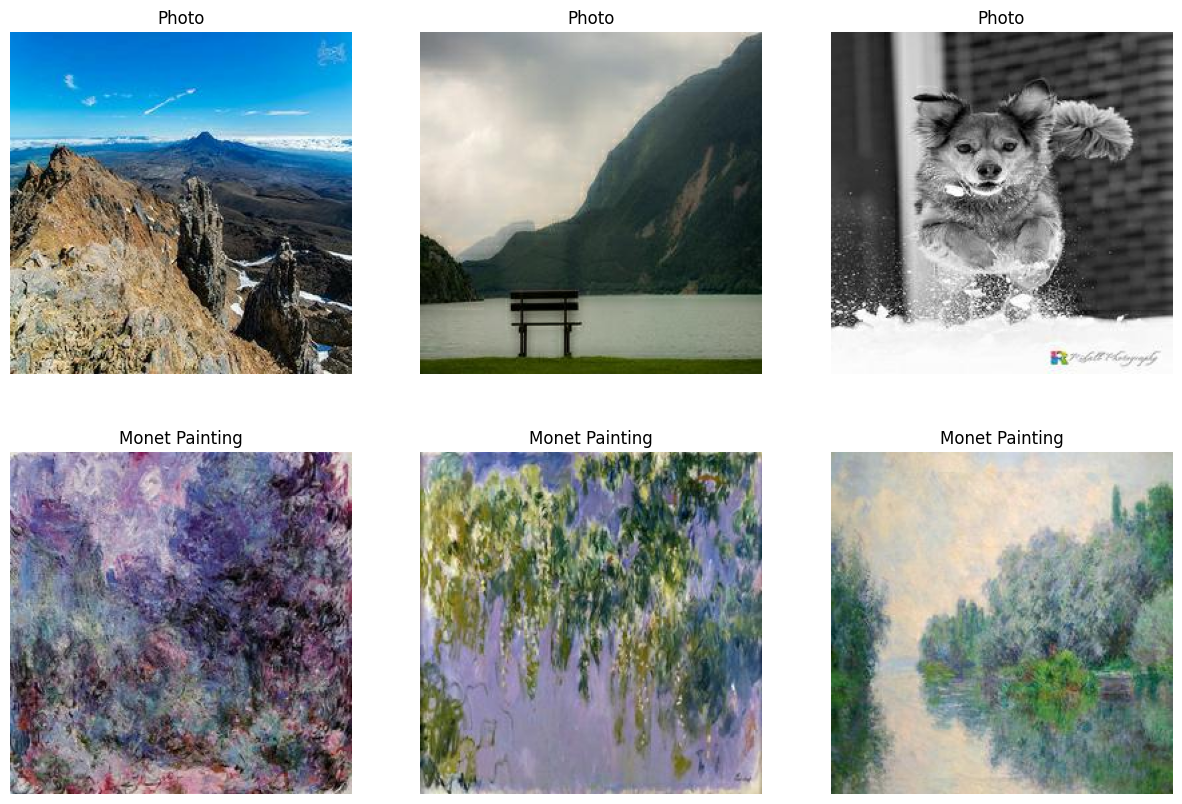

**Observations about pixel distributions**

I plotted the pixel values for the photo images and the Monet images accross the different color channels and obtained the following figures

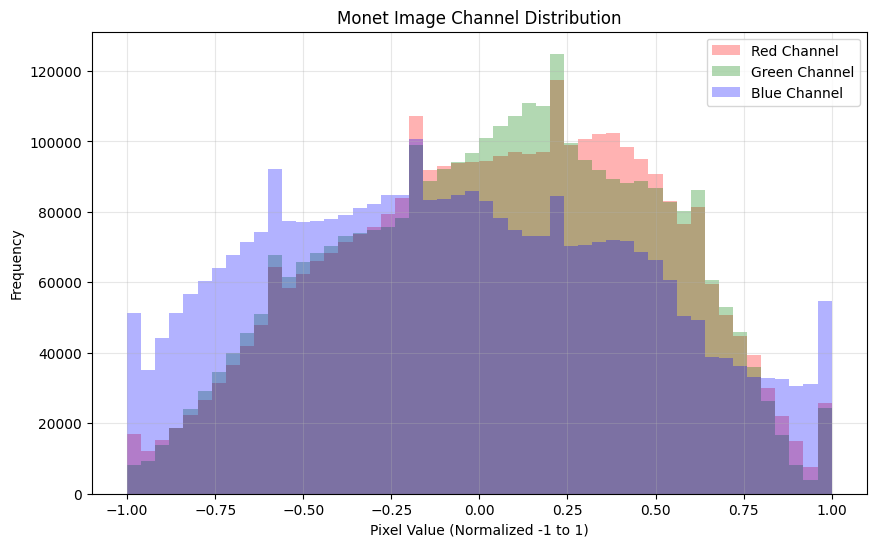
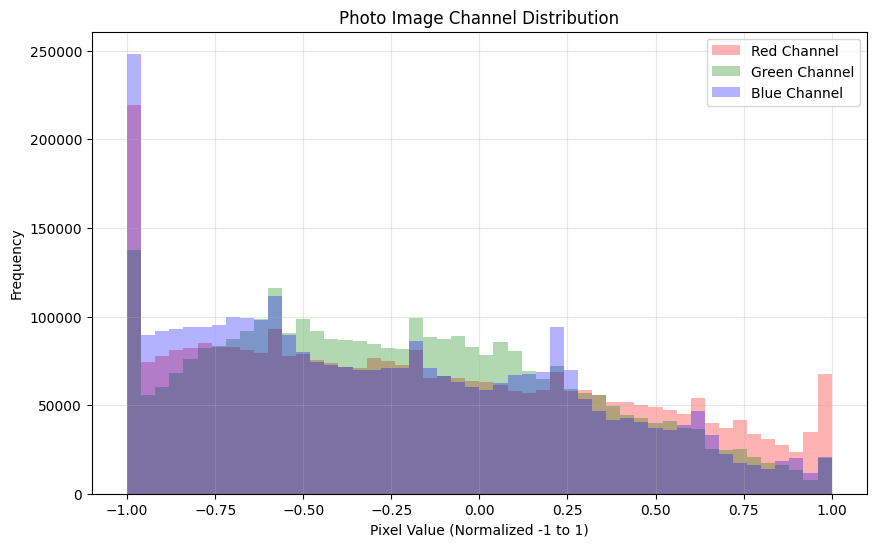

By looking at the results, I have the following observations:
* Photos have a similar distribution across all color channels compare to Monet images, which have a higher frequency on the green and red channel compared to the blue channel. This makes sense since `Monet` liked to capture colorful bright images, which would tend to have a higher frequency in the use of red and green colors. Also it makes sense for the photos to have similar distributions across all channels since there is no specific `style` associated with them
* Also,k the Monet distribution highlights the fact that its style does not use black, which is highlighted by the fact that it does not have a big spike around -1 like the photo distribution does
* Also, real photos often have deep shadows and high contrast (the difference between light and dark), and rhe data is heavily skewed toward the dark end, which is aligned with my expectations

These differences highlight the domain gap that my model will need to learn: Model needs to learn to eliminate the black from the photos in order to make them monet style and instead use dark blue, the model also needs to learn to shift image to have a warm color with red/green dominance, and it should also shift the photo pixel distribution to be more centered, which would cause the photos to have a mid-tone dominance.

Also, I ran a Sobel or Laplacian filter over a batch of Monets and a batch of Photos to extract edge maps and calculate the mean magnitude of these edges, and plotted a histogram comparing the "Edge Energy" (sum of edge magnitude) for Photos vs. Monets. I did this in order to confirm that photos will have a "long tail" of high-energy edges (sharp objects) and Monet images will be concentrated in lower energy (soft strokes). If sso, this is a key insight that the Discriminator needs to learn in order to punish the Generator for being "too sharp" when creating the Monet style.

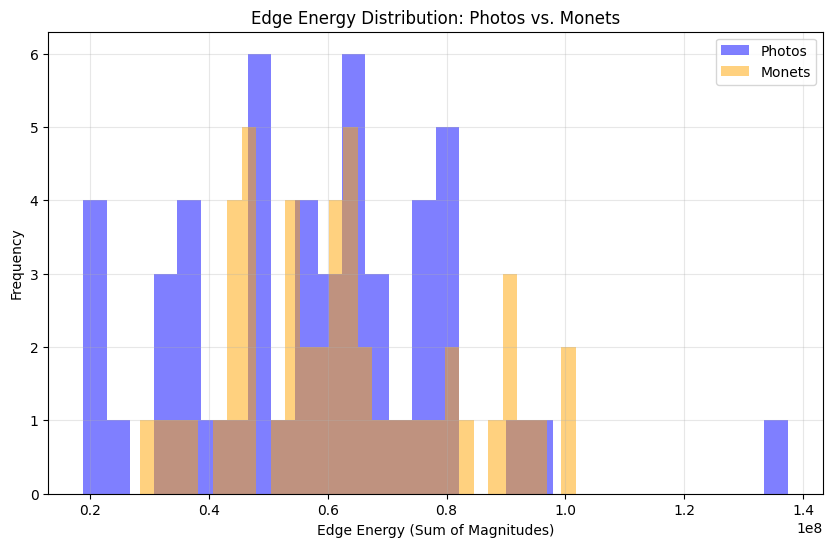

The plot reveals the following: 
* Photos have high frequency on the Low Energy (Left) likely due to photos with large smooth areas (clear blue skies, smooth walls, or underexposed dark shadows where detail is lost),l while also having High Energy (Right), which are likely due to crisp, digital photos with hard edges.
* On the other hand, Monet images have a distribution that is tightly clustered in the middle likely due to the fact that Monet didn't paint smooth gradients; he used distinct brushstrokes everywhere. Also, he didn't paint "razor sharp" edges. Everything is slightly softened by the brush.

This observations confirm that the discriminator will punish the generator if the generated images are either `too soft` or `too sharp`.

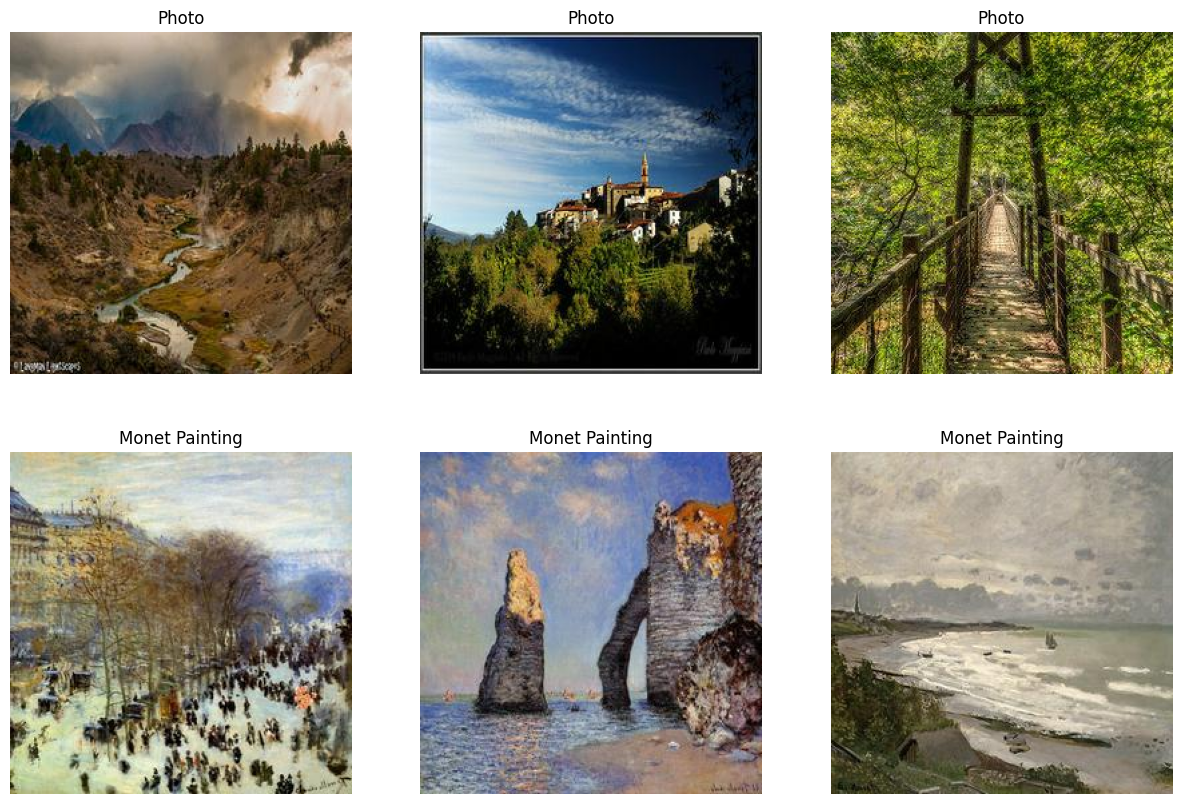

Sample image shape: (256, 256, 3)
Data Loaded. Monet Files: 5


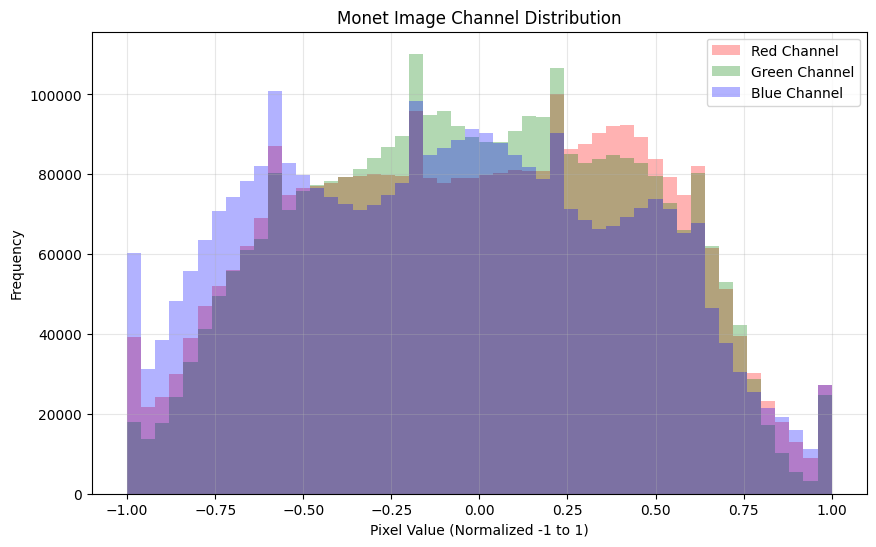

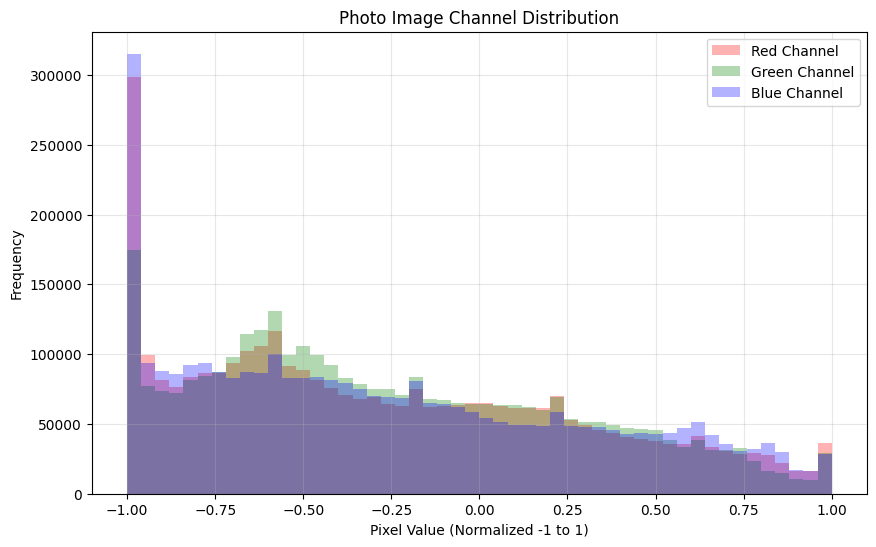

Computing edge energies for Photos...
Computing edge energies for Monets...


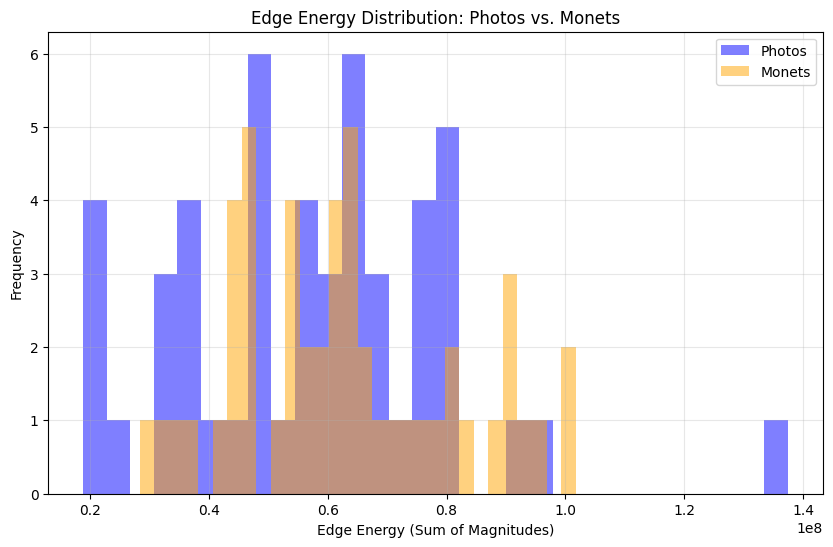

In [4]:
photo, monet = grab_randos(photo_display, monet_display)
plot_3_3(photo, monet)
# get the pixel values of a sample image
sample_image_path = os.path.join(photo_display, photo[0])
sample_image = plt.imread(sample_image_path)
print(f"Sample image shape: {sample_image.shape}")

# Run the function to create the tfrecord objects
monet_ds = load_dataset(MONET_FILENAMES).batch(1).shuffle(1000).prefetch(tf.data.AUTOTUNE)
photo_ds = load_dataset(PHOTO_FILENAMES).batch(1).shuffle(1000).prefetch(tf.data.AUTOTUNE)

print(f"Data Loaded. Monet Files: {len(MONET_FILENAMES)}")

# adding histogram of pixel values for monet and then photo images to compare the distributions
import matplotlib.pyplot as plt

def plot_pixel_histogram(dataset, title):
    """
    Plots the histogram of pixel values for the provided dataset, 
    separated by Red, Green, and Blue channels.
    """
    r_values = []
    g_values = []
    b_values = []
    
    print(f"Collecting data for {title}...")
    
    # Take 50-100 batches (Reduced to 50 for speed, adjust as needed)
    for batch in dataset.take(50): 
        img = batch.numpy()
        
        # Handle shape: TF usually gives (Batch, Height, Width, Channels) -> (B, H, W, 3)
        # Channel 0 = Red, 1 = Green, 2 = Blue
        if img.ndim == 4:
            r = img[:, :, :, 0]
            g = img[:, :, :, 1]
            b = img[:, :, :, 2]
        # Handle unbatched: (Height, Width, Channels) -> (H, W, 3)
        elif img.ndim == 3:
            r = img[:, :, 0]
            g = img[:, :, 1]
            b = img[:, :, 2]
        else:
            continue
            
        r_values.extend(r.flatten())
        g_values.extend(g.flatten())
        b_values.extend(b.flatten())

    plt.figure(figsize=(10, 6))
    
    # Plot 3 histograms with transparency (alpha) to see overlaps
    plt.hist(r_values, bins=50, range=(-1, 1), color='red', alpha=0.3, label='Red Channel')
    plt.hist(g_values, bins=50, range=(-1, 1), color='green', alpha=0.3, label='Green Channel')
    plt.hist(b_values, bins=50, range=(-1, 1), color='blue', alpha=0.3, label='Blue Channel')
    
    plt.title(title)
    plt.xlabel("Pixel Value (Normalized -1 to 1)")
    plt.ylabel("Frequency")
    plt.legend() # This adds the key (Red/Green/Blue labels)
    plt.grid(True, alpha=0.3)
    plt.show()

# Run the function
plot_pixel_histogram(monet_ds, "Monet Image Channel Distribution")
plot_pixel_histogram(photo_ds, "Photo Image Channel Distribution")

#Run a Sobel or Laplacian filter over a batch of Monets and a batch of Photos to extract edge maps. Calculate the mean magnitude of these edges.
# Plot: A histogram comparing the "Edge Energy" (sum of edge magnitude) for Photos vs. Monets.
import cv2
def compute_edge_energy(image):
    """Computes the edge energy of an image using the Sobel filter."""
    # Convert to numpy array if it's a tensor
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Compute Sobel edges
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    
    # Compute magnitude of edges
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # Return the sum of magnitudes as edge energy
    return np.sum(magnitude)
def plot_edge_energy_histogram(photo_dataset, monet_dataset):
    """Plots a histogram comparing edge energy for Photos vs. Monets."""
    photo_edge_energies = []
    monet_edge_energies = []
    
    print("Computing edge energies for Photos...")
    for batch in photo_dataset.take(50):  # Take 50 batches for speed
        for img in batch:
            img = ((img + 1) * 127.5).numpy().astype(np.uint8)  # Denormalize to [0, 255]
            edge_energy = compute_edge_energy(img)
            photo_edge_energies.append(edge_energy)
    
    print("Computing edge energies for Monets...")
    for batch in monet_dataset.take(50):  # Take 50 batches for speed
        for img in batch:
            img = ((img + 1) * 127.5).numpy().astype(np.uint8)  # Denormalize to [0, 255]
            edge_energy = compute_edge_energy(img)
            monet_edge_energies.append(edge_energy)
    
    plt.figure(figsize=(10, 6))
    
    # Plot histograms
    plt.hist(photo_edge_energies, bins=30, alpha=0.5, label='Photos', color='blue')
    plt.hist(monet_edge_energies, bins=30, alpha=0.5, label='Monets', color='orange')
    
    plt.title("Edge Energy Distribution: Photos vs. Monets")
    plt.xlabel("Edge Energy (Sum of Magnitudes)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
# Run the edge energy histogram plot
plot_edge_energy_histogram(photo_ds, monet_ds)

# Dmodel architecture

In this section I describe my rationale for the model architecture.

I plan to have the following architecture:
* Generator `(U-Net Architecture)`:
    * Downsample from 256 to just 1: this will shrink the image size and increases the model's ability to capture latent features within the training data
    * Upsample back to 256 from 1: This is is basically the opposite of the downsample section, where the generator outputs the image from the learned latent features
    * Note that this follows the U-net architecture. I chose this architecture because it is a good choice for image-to-image translation due to its unique ability to preserve spatial details. This is because U-net adds skip connections between the different downsample and upsample layers that help prevent the model from completely eliminating all of the fine details that would make a photo a `Monet` style painting.
* Discriminator: this is the section of the model that identifies whether the provided image is real or generated. I am using a `PatchGan` architecture, which outputs a grid of numbers where each number represents the "realness" of a specific input image. With this architecture, the generator only receives a perfect score if every single patch of the image looks like Monet
    * In summary, `PatchGan` is the correct architecture because:
        * Focuses on high-frequency details like texture, which is important to understand the Monet style
        * It is computational efficient: because this architecture only uses convolutional layers and no massive dense layers, it has fewer parameters, and as a result, it is more computationally efficient than `Standard DCGAN`
        * Translation invariance: this architecture applies the same discriminator filter acrosst the whole image, which is good for this competition since the competition's goal is for style transfer of Monet style to real photos, so this ensures the style is consistent across the entire canvas

Hyperparameter choices and reasoning:
* The downsample and upsample layers use `instance normalization` because this keeps the style of each image independent, which is critical for style transfer. This operation calculates statistics for each image independently, which removes contrast/brightness information specific to that one photo, and by stripping away the photo's original lighting statistics, the model creates a blank canvas for the generator to paint the new Monet style onto. This preserves the content of the photo like edges/shapes, but it simpifies the style so that it can be replaces by the generator
    * I chose not to use `batch normalization` because this operation would force every image in the batch to have the same mean and variance, which would eliminate features in the data that would be useful for the operation of style transfer. This is because in style transfer, the style is mathematically represented by contrast, brightness and other important qualities of the images, and if I had used BN, it would get rid of these important features of the Monet style, which would prevent the model from being able to effectively do the transfer style operation
    * The other option was `not to use any normalization at all`. This is not a realistic option because if I had chose to not implement any normalization, the model would end up with exploding gradients, and `instance normalization` provides the stability benefits of normalization without the destructive side effects of Batch Normalization
    * Note that effects of instance vs batch normalization effects are described in Ulyanov et al. in the paper Instance Normalization: The Missing Ingredient for Fast Stylization (2016)
* Activation function: I am using `leakyRelu` as opposed to `Relu` because `leakyRelu` allows for negative outputs from the activation functions, which prevents neurons from dying
* Dropout layer: I am placing a `50%` dropout layer to the upsample architecture of the model. This is important because it introduces stochasticity to the model generation of the paintings, which allows it to generate varied textures, rather than just overfitting and memorizing the training data
    * Note that I am not using a droput layer for the downsample section of the model because this section is about stripping away noise and irrelevant details to find the latent representation of the image, and introducing dropout layers here may break the learned latent features of the training data, which may make the model create a completely different output from the input `photo`, which would not be conducive to the task of modifying an input photo into a painting in the style of Monet.
* `Skip connection layer`: Note that I added to this model because due to the depth of the upsample and downsample layers makes the model susceptible to exploding and vanishing gradients, and the skip connection allows the model to keep the gradient alive because it creates a direct connection in between the different layers of the model that is not affected by the multiplication of a large or very small matrix of weight values

**Other notable architectures/Loss functions I could have used and why i did not use them:**
* For the Generator: 
    * I did not use other architectures like a Residual Network for the generator architecture because that would be best used for transformations where the input and the output look very similar, and this competition is about learning a specific style and applying it to any photo
    * Additionally, a standard encoder/decoder architecture would not be useful here because, given that there are no skip connections, the model would remove significant detail from a training image, which would result in blurry images
* For the Discriminator:  
    * Global discriminator `Standard DCGAN`, which takes the image through dense layers and outputs a single scalar value for the whole image (0 or 1). This type of architecture would not be good for this competition because it focuses mostly on shape and structure, and it would miss other features like texture, which are very important for this exercise since that is where the style of Monet could be illustrated
    * Another alternative is `PixelGan`, which classifies every pixel independently of an input image as real or fake. A model like this would be too specific, and even though it may be great at understanding the needed colors and textures for every pixel, it loses track of spatial context, which is also important for this competition. 

* For the loss functions reasoning:

    * Using MSE for the adversarial Loss. This loss type ensures the model keeps on learning even if the Discriminator gets too good, which will be the case at the beginning of the training process while the Generator is still learning. MSE penalizes data points based on how far they are from the decision boundary. Even if the Discriminator correctly identifies an image as "Fake," MSE still pushes the Generator to move that fake image closer to the "Real" distribution, which leads to more stable training and higher quality images than using BCE as the adversarial loss
    * Using L1 loss as the consistency loss, which ensures that if the model translates photo--> Monet--> Photo, it outputs the original image. If instead, I had use L2(MSE) for image reconstruction, the model would minimize massive errors, which would average pixel values and create blurry, fuzzy images. On the other hand, L1 minimizes the absolute difference, which does not penalize large errors as heavily as L2, but it penalies small errors more, which ends up producing sharper images with crisp edges, which is very important when preserving the original details of the photograph that the monet style was applied on
    * For the identify loss, I am also using L1(MSE): This loss measures what happens when I input a Monet painting into a Monet generator. Ideally nothing would happen, and using L1 loss here forces the generator to respect the original color palette of the input if it already resembles the target style, which prevents the model from hallucinating unnecessary changes 


Plan:
* Build, compile and train the model
* I plan to use CycleGan architecture
* Explain the architecture: mention the downsample and upsample architecture and choice of parameters for loss functions and why

In [3]:
# Code for the model architecture

# Build the downsample block of the generator

def downsample_builder(filters, size, apply_instance_norm=True):
    """This function builds the downsample block of the generator model"""
    initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Now create a linear stack of layers that will contain the downsampling block
    result = keras.Sequential()

    # add the convolutional layer
    # filter: dictates how many features to learn
    # size : kernel size
    # strides: how much to slide the kernel, which also downsamples the image
    result.add(keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                   kernel_initializer=initializer, use_bias=False))
    
    # apply the instance normalization if specified
    if apply_instance_norm:
        result.add(keras.layers.GroupNormalization(groups=-1))
    # add the leaky relu activation
    result.add(keras.layers.LeakyReLU())
    
    #return the created layer
    return result

# Build the upsample block of the generator

def upsample_builder(filters, size, apply_droput=True):
    """This function builds the upsample block of the generator model"""
    initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    # now create the sequential stack of layers that will contain the upsampling block
    result = keras.Sequential()

    # Create the deconvolutional layer
    result.add(keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                            kernel_initializer=initializer, use_bias=False))
    # apply instance normalization
    result.add(keras.layers.GroupNormalization(groups=-1))

    # apply dropout if specified
    if apply_droput:
        result.add(keras.layers.Dropout(0.5))
    
    # add the relu activation
    result.add(keras.layers.ReLU())
    
    # return the created layer
    return result

# use the downsample and upsample blocks to create the generator model
def Generator():
    """This function creates the generator model using the downsample and upsample blocks"""
    # Create the input layer based on the information about the image size
    inputs = keras.layers.Input(shape=[256, 256, 3])
    # Create the downsample layers

    downsample_block = [
        downsample_builder(64, 4, apply_instance_norm=False),
        downsample_builder(64, 4),
        downsample_builder(64, 4),
        downsample_builder(64, 4),
        downsample_builder(128, 4),
        downsample_builder(256, 4),
        downsample_builder(512, 4),
        downsample_builder(512, 4),
    ]
    # Create the upsample layers
    upsample_block = [
        upsample_builder(512, 4),
        upsample_builder(512, 4),
        upsample_builder(256, 4),
        upsample_builder(128, 4),
        upsample_builder(64, 4, apply_droput=False),
        upsample_builder(64, 4, apply_droput=False),
        upsample_builder(64, 4, apply_droput=False)]
    # Create the output layer of the upsample block
    initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    output_layer = keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                            kernel_initializer=initializer, activation='tanh')
    # Add the skip connections of the layers
    x = inputs
    skips = []
    for down in downsample_block:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(upsample_block, skips):
        x = up(x)
        x = keras.layers.Concatenate()([x, skip])
    x = output_layer(x)
    return keras.Model(inputs=inputs, outputs=x)

# Create the discriminator of the model
def Discriminator_block():
    """This function creates the discriminator model"""
    initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    inputs = keras.layers.Input(shape=[256, 256, 3])
    down1 = downsample_builder(64, 4, apply_instance_norm=False)(inputs)
    down2 = downsample_builder(128, 4)(down1)
    down3 = downsample_builder(256, 4)(down2)
    down4 = downsample_builder(256, 4)(down3)
    zero_pad1 = keras.layers.ZeroPadding2D()(down4)
    conv = keras.layers.Conv2D(512, 4, strides=1,
                               kernel_initializer=initializer,
                               use_bias=False)(zero_pad1)
    norm1 = keras.layers.GroupNormalization(groups=-1)(conv)
    leaky_relu = keras.layers.LeakyReLU()(norm1)
    zero_pad2 = keras.layers.ZeroPadding2D()(leaky_relu)
    output = keras.layers.Conv2D(1, 4, strides=1,
                                 kernel_initializer=initializer)(zero_pad2)
    return keras.Model(inputs=inputs, outputs=output)

# Create the generator and discriminator models
monet_generator = Generator()
photo_generator = Generator()
monet_discriminator = Discriminator_block()
photo_discriminator = Discriminator_block()

# Print the model summaries
monet_generator.summary()
photo_generator.summary()
monet_discriminator.summary()
photo_discriminator.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │     65,664 │ sequential[0][0]  │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │     65,664 │ sequential_1[0][… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │     65,664 │ sequential_2[0][… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 128) │    131,328 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 256) │    524,800 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  2,098,176 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,195,328 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,195,328 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,389,632 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4, 768) │          0 │ sequential_9[0][… │
│ (Concatenate)       │                   │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 256) │  3,146,240 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8, 384) │          0 │ sequential_10[0]… │
│ (Concatenate)       │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │    786,688 │ concatenate_2[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 24,132,867 (92.06 MB)

 Trainable params: 24,132,867 (92.06 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 128, 128,  │      3,072 │ input_layer_16[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 64, 64,    │     65,664 │ sequential_15[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 32, 32,    │     65,664 │ sequential_16[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_18       │ (None, 16, 16,    │     65,664 │ sequential_17[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_19       │ (None, 8, 8, 128) │    131,328 │ sequential_18[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_20       │ (None, 4, 4, 256) │    524,800 │ sequential_19[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_21       │ (None, 2, 2, 512) │  2,098,176 │ sequential_20[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_22       │ (None, 1, 1, 512) │  4,195,328 │ sequential_21[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_23       │ (None, 2, 2, 512) │  4,195,328 │ sequential_22[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 2, 2,      │          0 │ sequential_23[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_24       │ (None, 4, 4, 512) │  8,389,632 │ concatenate_7[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 4, 4, 768) │          0 │ sequential_24[0]… │
│ (Concatenate)       │                   │            │ sequential_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_25       │ (None, 8, 8, 256) │  3,146,240 │ concatenate_8[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 8, 8, 384) │          0 │ sequential_25[0]… │
│ (Concatenate)       │                   │            │ sequential_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_26       │ (None, 16, 16,    │    786,688 │ concatenate_9[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 16, 16,    │          0 │ sequential_26[0]

 Total params: 24,132,867 (92.06 MB)

 Trainable params: 24,132,867 (92.06 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_30 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_31 (Sequential)      │ (None, 64, 64, 128)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_32 (Sequential)      │ (None, 32, 32, 256)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_33 (Sequential)      │ (None, 16, 16, 256)    │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 15, 15, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_31          │ (None, 15, 15, 512)    │         1,024 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 17, 17, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 14, 14, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,814,657 (14.55 MB)

 Trainable params: 3,814,657 (14.55 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_34 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_35 (Sequential)      │ (None, 64, 64, 128)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_36 (Sequential)      │ (None, 32, 32, 256)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_37 (Sequential)      │ (None, 16, 16, 256)    │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 18, 18, 256)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 15, 15, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_35          │ (None, 15, 15, 512)    │         1,024 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 17, 17, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 14, 14, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,814,657 (14.55 MB)

 Trainable params: 3,814,657 (14.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Create the loss functions and optimizers for the models
# use torch optimizers since keras backend is set to torch

import torch.optim as optim
import torch.nn as nn

# Optimizers for the generators and discriminators
m_gen_opt = optim.Adam(monet_generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
p_gen_opt = optim.Adam(photo_generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
m_disc_opt = optim.Adam(monet_discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
p_disc_opt = optim.Adam(photo_discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Loss functions
adv_loss_fn = nn.MSELoss()
cycle_loss_fn = nn.L1Loss()

def generator_loss_fn(fake_output):
    """This function calculates the generator adversarial loss"""
    target = torch.ones_like(fake_output)
    loss = adv_loss_fn(fake_output, target)
    return loss
def discriminator_loss_fn(real_output, fake_output):
    """This function calculates the discriminator loss"""
    real_target = torch.ones_like(real_output)
    fake_target = torch.zeros_like(fake_output)
    real_loss = adv_loss_fn(real_output, real_target)
    fake_loss = adv_loss_fn(fake_output, fake_target)
    total_loss = (real_loss + fake_loss) * 0.5
    return total_loss
def cycle_consistency_loss_fn(real_image, cycled_image):
    """This function calculates the cycle consistency loss"""
    loss = 10* cycle_loss_fn(cycled_image, real_image)
    return loss
def identity_loss_fn(real_image, same_image):
    """This function calculates the identity loss"""
    loss = 5* cycle_loss_fn(same_image, real_image)
    return loss

# train the model
import time
import tensorflow as tf # Assuming tf is needed for the dataset iterator
import torch

# Initialize lists to keep track of losses
monet_gen_losses = []
photo_gen_losses = []
monet_disc_losses = []
photo_disc_losses = []

# 20 Epochs
epochs = 20 

print("Starting Training Loop...")

for epoch in range(epochs):
    start_time = time.time()
    
    # Iterate over the dataset
    for i, (real_monet, real_photo) in enumerate(tf.data.Dataset.zip((monet_ds, photo_ds))):
        
        # Convert TF tensors to PyTorch tensors and move to GPU
        real_monet = torch.tensor(real_monet.numpy()).float().to("cuda")
        real_photo = torch.tensor(real_photo.numpy()).float().to("cuda")
        
        # --- Train Generators ---
        # 1. Zero out gradients for both generators
        m_gen_opt.zero_grad()
        p_gen_opt.zero_grad()
        
        # 2. Forward pass (Generate images)
        fake_monet = monet_generator(real_photo)
        cycled_photo = photo_generator(fake_monet)
        
        fake_photo = photo_generator(real_monet)
        cycled_monet = monet_generator(fake_photo)
        
        # 3. Identity mapping (for identity loss)
        same_monet = monet_generator(real_monet)
        same_photo = photo_generator(real_photo)
        
        # 4. Discriminator checks on fake images
        disc_fake_monet = monet_discriminator(fake_monet)
        disc_fake_photo = photo_discriminator(fake_photo)
        
        # 5. Calculate Generator Losses
        monet_gen_loss = generator_loss_fn(disc_fake_monet)
        photo_gen_loss = generator_loss_fn(disc_fake_photo)
        
        total_cycle_loss = cycle_consistency_loss_fn(real_monet, cycled_monet) + \
                           cycle_consistency_loss_fn(real_photo, cycled_photo)

        total_identity_loss = identity_loss_fn(real_monet, same_monet) + \
                              identity_loss_fn(real_photo, same_photo)
        
        # Combine all generator losses
        total_gen_loss = monet_gen_loss + photo_gen_loss + total_cycle_loss + total_identity_loss
        
        # 6. Backpropagate & Update Generators (Combined step)
        total_gen_loss.backward()
        m_gen_opt.step()
        p_gen_opt.step()
        
        # --- Train Discriminators ---
        m_disc_opt.zero_grad()
        p_disc_opt.zero_grad()
        
        # 1. Check Real vs Fake
        disc_real_monet = monet_discriminator(real_monet)
        disc_fake_monet = monet_discriminator(fake_monet.detach()) 
        
        disc_real_photo = photo_discriminator(real_photo)
        disc_fake_photo = photo_discriminator(fake_photo.detach())
        
        # Calculate Discriminator Losses
        monet_disc_loss = discriminator_loss_fn(disc_real_monet, disc_fake_monet)
        photo_disc_loss = discriminator_loss_fn(disc_real_photo, disc_fake_photo)

        # Append losses to lists
        monet_gen_losses.append(monet_gen_loss.item())
        photo_gen_losses.append(photo_gen_loss.item())      
        monet_disc_losses.append(monet_disc_loss.item())    
        photo_disc_losses.append(photo_disc_loss.item())
        
        # 3. Backpropagate & Update Discriminators
        monet_disc_loss.backward()
        photo_disc_loss.backward()
        m_disc_opt.step()
        p_disc_opt.step()
        
        if i % 500 == 0:
            print(f"Epoch {epoch+1}, Step {i}, Total Gen Loss: {total_gen_loss.item():.4f}")
            
    print(f"Time for epoch {epoch+1}: {time.time()-start_time:.2f} sec")

Starting Training Loop...
Epoch 1, Step 0, Total Gen Loss: 21.0890
Time for epoch 1: 83.60 sec
Epoch 2, Step 0, Total Gen Loss: 5.0086
Time for epoch 2: 80.76 sec
Epoch 3, Step 0, Total Gen Loss: 4.0330
Time for epoch 3: 80.91 sec
Epoch 4, Step 0, Total Gen Loss: 5.3948
Time for epoch 4: 80.30 sec
Epoch 5, Step 0, Total Gen Loss: 2.9052
Time for epoch 5: 80.43 sec
Epoch 6, Step 0, Total Gen Loss: 4.5955
Time for epoch 6: 80.44 sec
Epoch 7, Step 0, Total Gen Loss: 4.5216
Time for epoch 7: 80.63 sec
Epoch 8, Step 0, Total Gen Loss: 2.6780
Time for epoch 8: 80.36 sec
Epoch 9, Step 0, Total Gen Loss: 3.1745
Time for epoch 9: 81.13 sec
Epoch 10, Step 0, Total Gen Loss: 3.4839
Time for epoch 10: 81.18 sec
Epoch 11, Step 0, Total Gen Loss: 3.4126
Time for epoch 11: 80.90 sec
Epoch 12, Step 0, Total Gen Loss: 3.0951
Time for epoch 12: 80.71 sec
Epoch 13, Step 0, Total Gen Loss: 3.6850
Time for epoch 13: 81.00 sec
Epoch 14, Step 0, Total Gen Loss: 2.4044
Time for epoch 14: 80.87 sec
Epoch 15, S

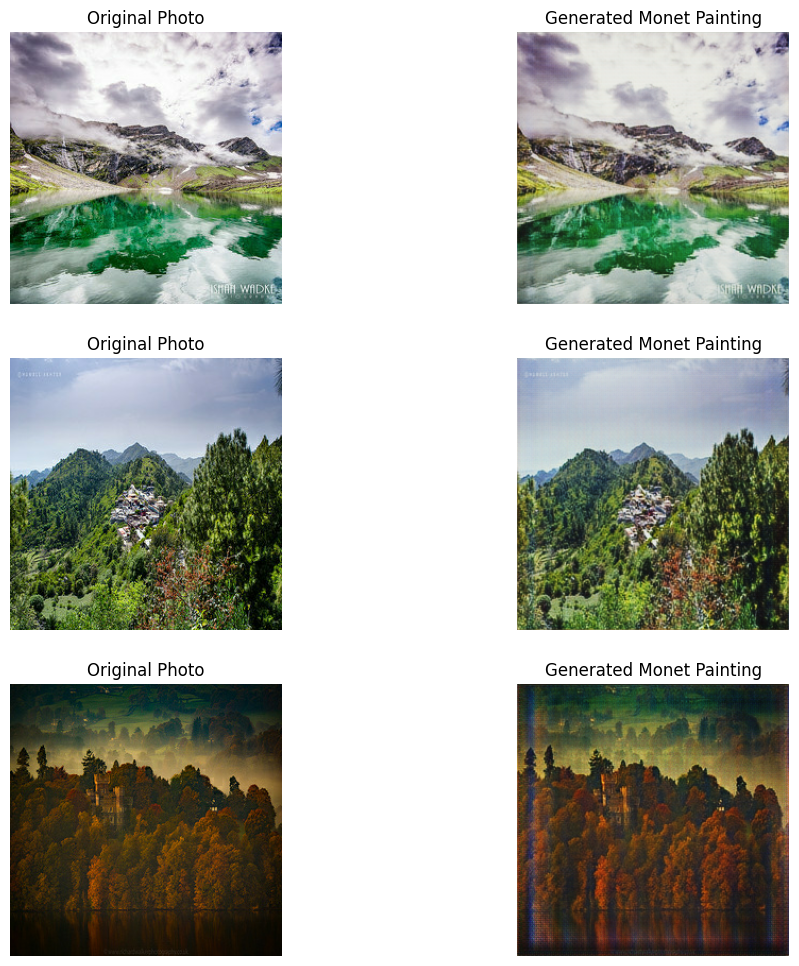

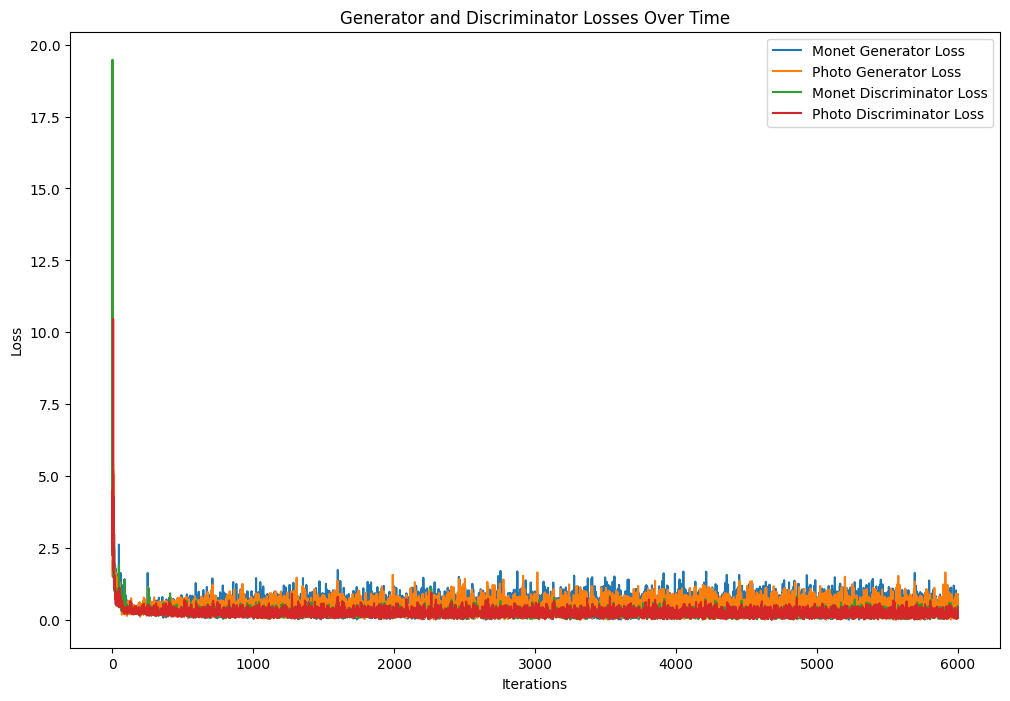

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Part 1: Visualize Generated Images ---

# Create a 3x2 subplot to display the results
f, ax = plt.subplots(3, 2, figsize=(12, 12))

# Create a fresh iterator
photo_iter = iter(photo_ds)

for i in range(3):
    # 1. Get the next photo (TensorFlow Tensor)
    try:
        photo_tf = next(photo_iter) # Shape: (1, 256, 256, 3)
    except StopIteration:
        break

    # 2. Convert TF -> Numpy -> PyTorch
    # We DO NOT permute here because the error shows your model expects (H, W, C)
    photo_torch = torch.tensor(photo_tf.numpy()).float()
        
    if torch.cuda.is_available():
        photo_torch = photo_torch.cuda()

    # 3. Generate the Monet painting
    monet_generator.eval()
    with torch.no_grad():
        fake_monet_torch = monet_generator(photo_torch) # Output Shape: (1, 256, 256, 3)
    monet_generator.train()

    # 4. Prepare for Plotting
    photo_plot = photo_tf.numpy()[0] 
    
    # Generated Fake: Detach, move to CPU, convert to numpy
    # No permute needed because output is already (N, H, W, C)
    fake_plot = fake_monet_torch.detach().cpu().numpy()[0]

    # 5. Rescale images from [-1, 1] to [0, 1] for matplotlib
    photo_plot = (photo_plot + 1) / 2.0
    fake_plot = (fake_plot + 1) / 2.0

    # 6. Plotting
    ax[i, 0].imshow(photo_plot)
    ax[i, 0].axis('off')
    ax[i, 0].set_title("Original Photo")

    ax[i, 1].imshow(fake_plot)
    ax[i, 1].axis('off')
    ax[i, 1].set_title("Generated Monet Painting")

plt.show()

# --- Part 2: Plot the Losses ---

def plot_losses(monet_gen_losses, photo_gen_losses, monet_disc_losses, photo_disc_losses):
    plt.figure(figsize=(12, 8))
    plt.plot(monet_gen_losses, label='Monet Generator Loss')
    plt.plot(photo_gen_losses, label='Photo Generator Loss')
    plt.plot(monet_disc_losses, label='Monet Discriminator Loss')
    plt.plot(photo_disc_losses, label='Photo Discriminator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses Over Time')
    plt.legend()
    plt.show()

if 'monet_gen_losses' in locals() and len(monet_gen_losses) > 0:
    plot_losses(monet_gen_losses, photo_gen_losses, monet_disc_losses, photo_disc_losses)
else:
    print("Loss lists are empty. Ensure you ran the updated training loop that saves losses.")

In [6]:
import shutil
import PIL
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

os.makedirs('images', exist_ok=True)

print("Generating images for submission...")
i = 1

for img_name in os.listdir(photo_display):
    # 1. Load image (H, W, C)
    image_path = os.path.join(photo_display, img_name)
    image = plt.imread(image_path)
    
    # 2. Convert to PyTorch Tensor
    image_tensor = torch.tensor(image).float()
    
    # 3. Add Batch Dimension: (H, W, C) -> (1, H, W, C)
    image_tensor = image_tensor.unsqueeze(0)
    
    # 4. Normalize
    image_tensor = (image_tensor / 127.5) - 1.0
    
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()
        
    # 5. Generate
    with torch.no_grad():
        fake_monet = monet_generator(image_tensor)
    
    # 6. Post-processing
    # Remove batch dim: (1, H, W, C) -> (H, W, C)
    fake_monet = fake_monet.cpu().detach().squeeze(0).numpy()
    
    # 7. Save
    fake_monet = ((fake_monet + 1) / 2.0 * 255).astype(np.uint8)
    save_path = os.path.join('images', f'generated_{i}.jpg')
    PIL.Image.fromarray(fake_monet).save(save_path)
    
    i += 1
    if i > 7500:
        break

print("Image generation completed.")
shutil.make_archive("/kaggle/working/images", 'zip', "images")

Generating images for submission...
Image generation completed.


'/kaggle/working/images.zip'

# Results and Analysis

In this section, I describe some hyperparameter tuning, the observed results as well as the performance of the model.
  
**Hyperparameter tuning-- learning rates, batch sizes, and architecture details:**
* Generator design choices: 
   * I only apply `dropout` in the `early upsample layers`: Dropout is placed in the upsampling path (decoder) to act as a noise source, introducing stochasticity that prevents overfitting and encourages the generation of robust textures. It is omitted from the downsampling path (encoder) to ensure the structural content of the original image is preserved without corruption.
   * Instance norm is not applied in the first downsample layer: This is done to preserve the original information of the input image, specifically its color distribution and brightness. If I normalize the first layer, I would discard the absolute "brightness" and "contrast" of the input image, and by skipping normalization on the first layer, you allow the network to learn its first set of features based on the true pixel values, rather than a modified, standardized version.
* Discriminator design choices: 
  * Notice that I did `not add any normalization to the first block of the downsampling` in the generator because I want the want the discriminator to see the raw brightness and color saturation of the input in order to effectively perform the classification
  * I added `4 downsampling layers` in the generator, which allows the model to learn increasingly complex combinations of features, and a stride of 2 here shrinks the image size by half, which increases the receptive field of the model
  * I also add `zero padding` within the discriminator model, which allows for final output grid to map correctly to the input patches.
  * I am also using no activation function in the final layer of the discriminator because the numerical stability of th model is better if I handle the Sigmoid calculation inside the loss function rather than inside the model layer.
* Optimizer design choices:
  * I am using Adam optimizer, which is the standard for GANs
  * I am also using a learning rate of LR=0.0002, and Beta1=0.5, which follows the design choices by the example provided in the Kaggle competition
* Loss functions: 
  * Using MSE for the adversarial Loss. This loss type ensures the model keeps on learning even if the Discriminator gets too good, which will be the case at the beginning of the training process while the Generator is still learning. MSE penalizes data points based on how far they are from the decision boundary. Even if the Discriminator correctly identifies an image as "Fake," MSE still pushes the Generator to move that fake image closer to the "Real" distribution, which leads to more stable training and higher quality images than using BCE as the adversarial loss
  * Using L1 loss as the consistency loss, which ensures that if the model translates photo--> Monet--> Photo, it outputs the original image. If instead, I had use L2(MSE) for image reconstruction, the model would minimize massive errors, which would average pixel values and create blurry, fuzzy images. On the other hand, L1 minimizes the absolute difference, which does not penalize large errors as heavily as L2, but it penalies small errors more, which ends up producing sharper images with crisp edges, which is very important when preserving the original details of the photograph that the monet style was applied on
  * For the identify loss, I am also using L1(MSE): This loss measures what happens when I input a Monet painting into a Monet generator. Ideally nothing would happen, and using L1 loss here forces the generator to respect the original color palette of the input if it already resembles the target style, which prevents the model from hallucinating unnecessary changes

**Results:**

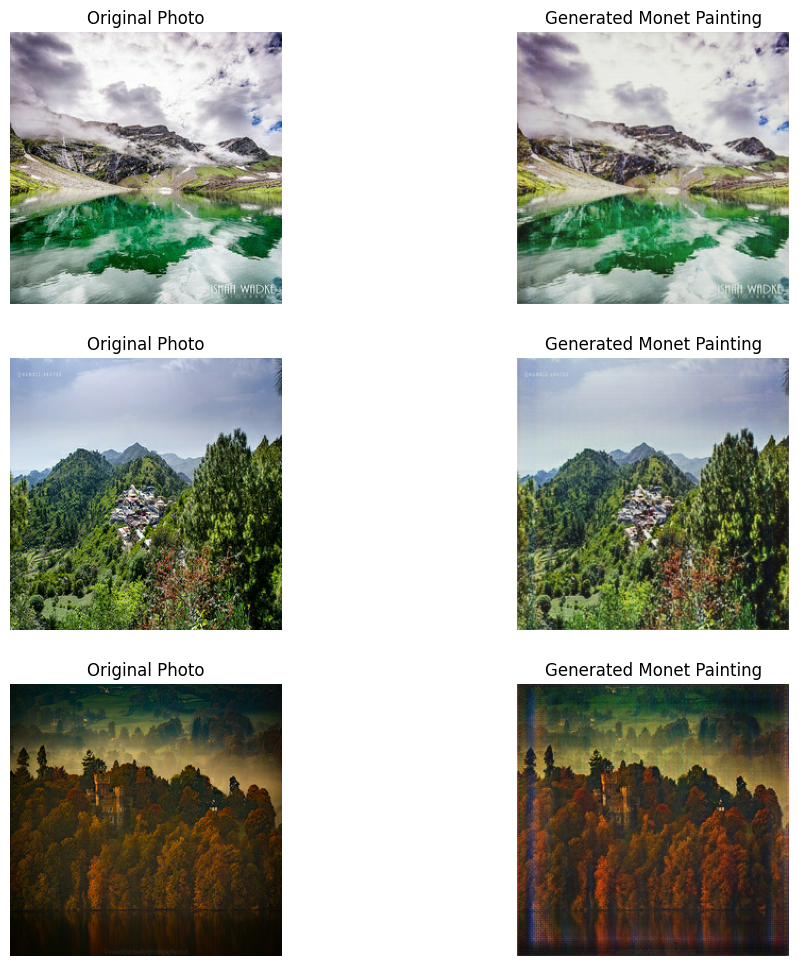

Above, I have copied the results of my model converting photos into Monet style paintings, and I have the following key observations:
* The model is good at creating the style of monnet in bright images, but it seems to generate some image artifacts with images that are on the darker side. This is could be due to the fact that the 'monet style' is always based on paintings that capture bright, vibrant, and colorful scenarios, so using a photo that is capturing a dark environment , the model forces bright, colorful textures into the dark areas where they do not belong. Some of these artifacts could also be due to the `ConvTranspose2d` layers I have in the generator upsampling blocks, which can create grid-like artifacts in the images due to kernel and stride number mismatch
* Despite the artifacts, the model seems to be good at generating texture like canvas in the input photos as well as the Monet style when dealing with bright environments being captured in the input photo

**Loss Plots**:

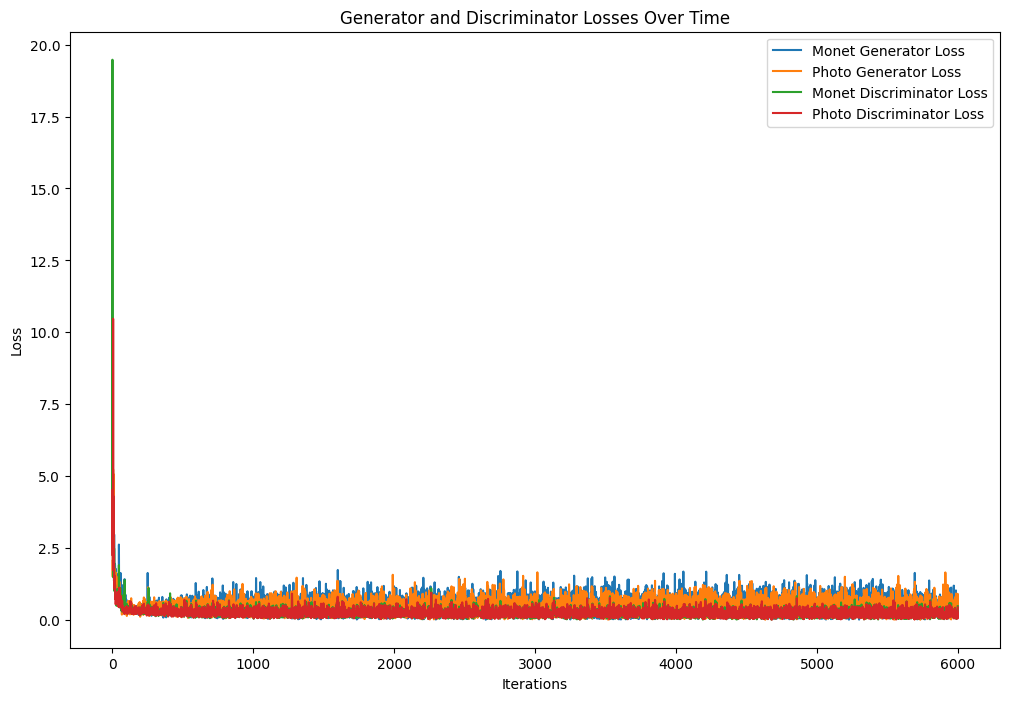

As it relates to the losses of the model, I have the following observations from the image attached above:
* All loses decrease exponentially and then oscillate while the model is training. This is normal and expected. This is due to the fact that when training `GANs`, the model is training an adversarial network composed of the Discriminator and the Generator, and these models are working against each other in the min-max game loop, which gets reflected in the loss oscillations reflected in the plot. Additionally, `GAN` models are not looking for a global minimum during training, they look for the Nash Equilibrium; therefore, in order to achieve this equilibrium, there is a lot of oscillations in the model losses. Also, the reason why all of the losses decrease exponetially at the beginning of the model is because at the beginning of training, it is easy for the discriminator to learn to tell apart random noise the generator creates from the real images, and it is easy for the generator to learn the general patterns that constitute an image, but as they both learn, it becomes increasingly difficult for them to learn the latent features of photos and the monet style; hence the oscillations in the loss plot.

**Reasoning on why some models or hyperparameters work well or why they do not**

* Something that did not work well was adding an extra downsample layers to the discriminator block instead of 3. This likely caused the discriminator to lose finer details and not be able to detect latent features more effectively
* The generator is still generating images with sharp edges and dark colors, which are not part of the Monet style as described earlier. Therefore, having such a high dropout rate may be hurting the ability of the generator to learn the Monet style.


**Troubleshooting procedure**:
* Increase numbner of epochs for the model to train in order to improve kaggle score
* Decrease number of downsample layers in the discriminator
* Decrease dropout rate in the generator as well as the number of layers with dropout

# Conclusion
This section goes over the conclusion of this project including explanation of kaggle submission, things that helped/did not help, things to try to do in the future.

* Results
* Things that helped/did not help with model learning and why
* Things to try in the future to improve model performance
More Epochs: You trained for 20 epochs. CycleGANs often benefit from longer training (30-50 epochs), usually with a "decay" phase where the learning rate slowly drops to zero.

**Model submission results with kaggle:**
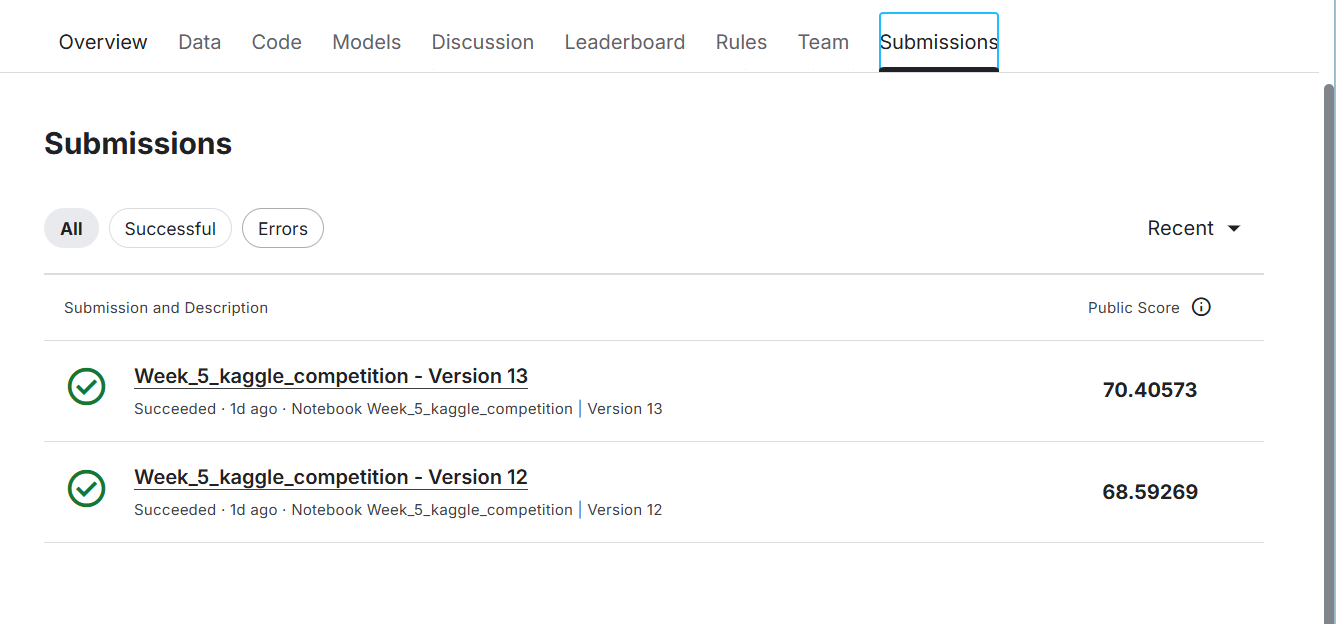

**Result interpretation**: A result of ~70 is a successful result. The best result in the score board is 34.8. A score of ~70 means the model successfully learned the Monet style, and if my model had a bug, the score would have been ~200. To achieve a higher score, I would need to train the model for higher number of epochs and a more sophisticated architecture like `U-net with Attention`.

**Things that helped with training**
* Dropout layer helped with allowing the generator model to not memorize the training data, and encourage the generation of Monet style textures. 
* Instance normalization instead of batch normalization also helped the model tremendously because it allowed the model to learn the specific characteristic of the image while also preventing overfitting
* The skip connections helped with the exploding and vanishing gradient problem given the deep structure of the model

**Things that did not help during training**
* Adding 4 downsample layers to the discriminator block instead of 3. The example code provided by Kaggle only had 3 downsample layers, and I think my extra layer may be oversimplifying the images too much to the point of affecting the discriminator's ability to effectively tell fake from real images

**Things to try in the future**:
* Training the model for longer. I think 20 epochs may not be enough for the `GAN` model to effectively train. Additionally, a learning rate decay/scheduling will also help with model training rather than keeping a constant learning rate
* Data Augmentation in order to generate more training data by applying random transformations would increase the training data for the model, and therefore, its performance because it would allow the model to train for more epochs without over-fitting the data
* Try a more complex model like U-net with Attention and assess if that improves performance



# References
*  Kaggle competition starter notebook by Amy Jang at https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
*  Instance Normalization: The Missing Ingredient for Fast Stylization (2016) by Ulyanov et al.